In [31]:
import requests, pandas as pd, re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Collect dataset
url = "https://newsdata.io/api/1/news?apikey=pub_81949539b1d4e40afc0b5933d66bda921b8d0&q=artificial%20intelligence"
response = requests.get(url).json()

df = pd.DataFrame([{
    "title": a.get("title"),
    "description": a.get("description")
} for a in response["results"]])

df = df.drop_duplicates(subset=["title", "description"]).reset_index(drop=True)

# 2. Clean text
def clean(t):
    t = "" if t is None else t.lower()
    return re.sub(r"[^a-z0-9 ]", " ", t)

df["text"] = (df["title"].fillna("") + " " + df["description"].fillna("")).apply(clean)

# 3. TF-IDF
tfidf = TfidfVectorizer(stop_words="english")
X = tfidf.fit_transform(df["text"])

# 4. Choose k using silhouette (2–5)
best_k, best_score = 0, -1
for k in range(2, 6):
    labels = KMeans(n_clusters=k, random_state=0).fit_predict(X)
    score = silhouette_score(X, labels)
    if score > best_score:
        best_k, best_score = k, score

print("Best k =", best_k)

# 5. Final clustering
kmeans = KMeans(n_clusters=best_k, random_state=0)
df["cluster"] = kmeans.fit_predict(X)

# 6. Print examples from each cluster

for c in sorted(df["cluster"].unique()):
    print(f"\n=== CLUSTER {c} ===")
    for t in df[df["cluster"] == c]["title"].head(5):
        print("-", t)

Best k = 2

=== CLUSTER 0 ===
- Trump Approves F-35 Jets for Saudi Arabia Ahead of MBS Visit
- Catholic Charities gets 4,200-pound food donation to fight hunger in Springfield
- Premier urges synthetic timber use for sustainability

=== CLUSTER 1 ===
- Battle of AI Titans: Elon Musk Calls Jeff Bezos a 'Copycat' After Amazon Founder Announces His Project Prometheus AI Startup
- AI adoption of key concern to Irish businesses shows Ibec report
- Absci Corporation (NASDAQ:ABSI) Receives Consensus Recommendation of “Moderate Buy” from Analysts
- Google’s Sundar Pichai Warns No Company Is Safe If Global AI Bubble Bursts
- AI Pet Platform FurGPT (FGPT) Developer Makes $50M Offer To Acquire DappRadar Crypto Platform


Best k = 2


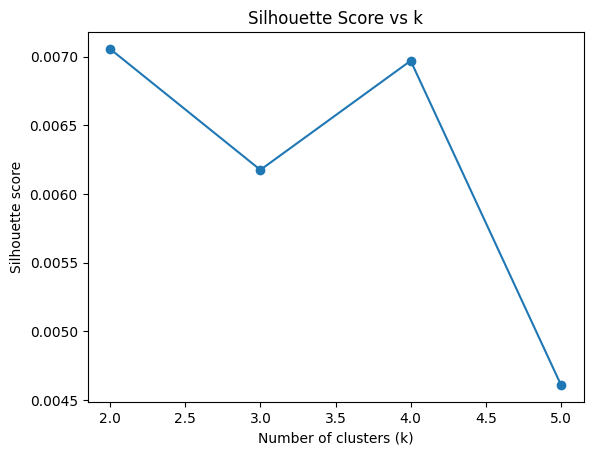

In [28]:
# 4. Choose k using silhouette (2–5) and store scores
sil_scores = []
k_values = range(2, 6)

for k in k_values:
    labels = KMeans(n_clusters=k, random_state=0).fit_predict(X)
    score = silhouette_score(X, labels)
    sil_scores.append(score)
    if score > best_score:
        best_k, best_score = k, score

print("Best k =", best_k)

# Plot silhouette score vs k
plt.figure()
plt.plot(list(k_values), sil_scores, marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs k")
plt.show()
